<a href="https://colab.research.google.com/github/alelovato/CECAM_School/blob/main/deuteron_NQS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deuteron with a LO, pionless-EFT potential

This notebook computes the ground-state of the deuteron, from the pionless-EFT Hamiltonian

$$ H = -\frac{\hbar^2}{2m} \sum_{i=1}^{npart} \vec{\nabla}_i^2 + \sum_{i<j}\sum_{p=1}^4v^p(r_{ij})O^p_{ij}$$

where

$$O^p_{ij} = 1, \tau_{ij}, \sigma_{ij}, \sigma_{ij}\tau_{ij}$$


You can use a neural-network Slater-Jastrow ansatz of the form:

$$ \Psi(X) = e^{\mathcal{U}(\mathbf{r_1},\mathbf{r_2})} \Phi(S) $$

In its simplest form, you can ignore the Slater determinant, and the spin-isospin degrees of freedom, since

$$ |\Phi(S)\rangle = \langle S | \frac{1}{\sqrt{2}}[|p\uparrow\rangle_1 |n\uparrow\rangle_2 - |n\uparrow\rangle_1 |p\uparrow\rangle_2$$

Under this assumption, which is exact for the deuteron, $\tau_{12} = -3$, and $\sigma_{12} = 1$. Therefore, the potential reduces to

$$ \sum_{p=1}^4v^p(r_{ij})O^p_{ij} = v^c(r_{12}) -3 v^\tau(r_{12}) + v^\sigma(r_{12}) - 3 v^{\sigma\tau}(r_{12}) $$

In [ ]:
# Load the libraries that we need for this notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output

import jax
import jaxlib
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, grad, jit, vmap, pmap, jacfwd, jacrev
from jax.example_libraries import stax
from jax.lax import fori_loop
from functools import partial

from jax.example_libraries.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, Gelu, LogSoftmax, Softplus, Tanh,
                                   Sigmoid, elementwise, FanOut, FanInConcat)

from jax.nn.initializers import glorot_normal, normal, ones, zeros

from jax.tree_util import tree_flatten
from jax.flatten_util import ravel_pytree
from jax.scipy.linalg import cho_factor, cho_solve

In [ ]:
class NuclearPotential(object):
    """Class that evaluates the pionless-EFT potential "o" of PRC 103, 054003(2021)
    """
    def __init__(self):
        self.hc = 197.327053
        self.R0 = 1.54592984
        self.R1 = 1.83039397
        self.C01 = -5.27518671
        self.C10 = -7.04040080

    def v_2b(self, rr):
        pot_2b = jnp.zeros(6)
        C0_r = 1. / (jnp.sqrt(jnp.pi)*self.R0)**3*jnp.exp( -( rr / self.R0 )**2 )
        C1_r = 1. / (jnp.sqrt(jnp.pi)*self.R1)**3*jnp.exp( -( rr / self.R1 )**2 )
        pot_2b = pot_2b.at[0].set( 3. * ( self.C01 * C1_r + self.C10 * C0_r ) )
        pot_2b = pot_2b.at[1].set( self.C01 * C1_r - 3. * self.C10 * C0_r )
        pot_2b = pot_2b.at[2].set( -3. * self.C01 * C1_r + self.C10 * C0_r )
        pot_2b = pot_2b.at[3].set( -1. * ( self.C01 * C1_r + self.C10 * C0_r ) )
        pot_2b = pot_2b / 16. * self.hc
        return pot_2b

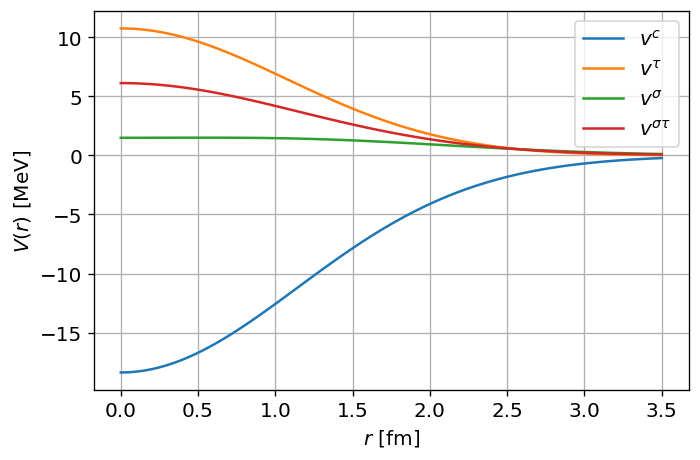

In [ ]:
# Plot the two-body potential
potential = NuclearPotential()
nr = 100
rr = np.linspace(0, 3.5, nr)
v_rr = np.zeros((6, nr))

for i, r in enumerate(rr):
    v_rr[:, i] = potential.v_2b(r)

# Plotting
figure(figsize=(6, 4), dpi=120)
plt.rcParams.update({'font.size': 12})

plt.plot(rr, v_rr[0, :], label=r'$v^c$')
plt.plot(rr, v_rr[1, :], label=r'$v^\tau$')
plt.plot(rr, v_rr[2, :], label=r'$v^\sigma$')
plt.plot(rr, v_rr[3, :], label=r'$v^{\sigma\tau}$')

plt.xlabel(r'$r\ \mathrm{[fm]}$')
plt.ylabel(r'$V(r)\ \mathrm{[MeV]}$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
class Wavefunction(object):
    """Create a wave function in ndim dimensions
       and for npart particles using a dense feed-forward neural net
    """
    def __init__(self, ndim : int, npart : int):
        self.ndim = ndim
        self.npart = npart
        self.activation = Tanh
        self.ndense = 16
        self.nlat = 16
        self.conf = 0.04

        self.npair = int(self.npart * (self.npart - 1) / 2)
        self.ip = jnp.empty(self.npair, dtype=int)
        self.jp = jnp.empty(self.npair, dtype=int)
        self.k = jnp.arange(self.npair)
        k = 0
        for i in range(self.npart-1):
            for j in range(i+1, self.npart):
                self.ip = self.ip.at[k].set(i)
                self.jp = self.jp.at[k].set(j)
                k += 1

        self.dense_init, self.dense_apply = stax.serial(
        Dense(self.ndense), self.activation,
        Dense(self.ndense), self.activation,
        Dense(self.ndense), self.activation,
        Dense(1)
        )

    def build(self, seed):
        net_in_shape = (-1, self.ndim)
        self.key = random.PRNGKey(seed)
        self.key, key_input = jax.random.split(self.key)
        _, net_params = self.dense_init(key_input, net_in_shape)
        net_params = jax.tree_util.tree_map(self.update_cast, net_params)
        flat_net_params = self.flatten_params(net_params)
        num_flat_params = flat_net_params.shape[0]
        return net_params, num_flat_params

    @partial(jit, static_argnums=(0,))
    def jastrow(self, params, r):
        def j_pair(k, params, r):
            r_ij = r[self.ip[k], :] - r[self.jp[k], :]
            return self.dense_apply(params, r_ij)
        return jnp.sum(vmap(j_pair, in_axes=(0, None, None))(self.k, params, r), axis=0)

    @partial(jit, static_argnums=(0,))
    def logpsi(self, params, r):
        rcm = jnp.mean(r, axis=0)
        r = ( r - rcm[None, :] )
        jastrow = self.jastrow(params, r)
        jastrow = jnp.reshape(jastrow, ())
        logpsi = jastrow - self.conf * jnp.sum(r**2)
        return logpsi

    @partial(jit, static_argnums=(0,))
    def vmap_logpsi(self, params, inputs):
        vmap_logpsi = vmap(self.logpsi, in_axes=(None, 0))(params, inputs)
        return vmap_logpsi

    @partial(jit, static_argnums=(0,))
    def flatten_params(self, parameters):
        flatten_parameters, self.unravel = ravel_pytree(parameters)
        return flatten_parameters

    @partial(jit, static_argnums=(0,))
    def unflatten_params(self, flatten_parameters):
        unflatten_parameters = self.unravel(flatten_parameters)
        return unflatten_parameters

    @partial(jit, static_argnums=(0,))
    def update_add(self, params, dparams):
        return params + dparams

    @partial(jit, static_argnums=(0,))
    def update_cast(self, params):
        return params.astype(jnp.float64)

In [ ]:
class Hamiltonian(object):
    """Expectation values of the kinetic and potential energies of
       a collection of independent harmonic oscillators.
    """
    def __init__(self, hbar : float, mass : float, ndim : int, npart : int, wavefunction : callable, potential : callable):
        self.hbar2m = hbar**2 / mass / 2
        self.ndim = ndim
        self.npart = npart
        self.wavefunction = wavefunction
        self.potential = potential
        self.npair = int(self.npart * (self.npart - 1) / 2)
        self.ip = jnp.empty(self.npair, dtype=int)
        self.jp = jnp.empty(self.npair, dtype=int)
        k = 0
        for i in range(self.npart-1):
            for j in range(i+1, self.npart):
                self.ip = self.ip.at[k].set(i)
                self.jp = self.jp.at[k].set(j)
                k += 1

    @partial(jax.jit, static_argnums=(0,))
    def v_pair(self, k, params, r):
        r_ij = r[self.ip[k], :] - r[self.jp[k], :]
        r_ij = jnp.sqrt(jnp.sum(r_ij**2))
        v_ij = self.potential.v_2b(r_ij)
        return v_ij

    @partial(jit, static_argnums=(0,))
    def potential_energy(self, r):
        """ The H2 potential is purely central, as:
        tau_12|psi> = -3 |psi>, sigma_12|psi> = |psi>, and sigma_12 tau_12|psi> = -3 |psi>
        so that
        V = <x|V|psi> / <x|psi> = sum_{i<j} ( v(r_ij)^c - 3 * v(r_ij)^tau + v(r_ij)^sigma - 3 * v(r_ij)^sigmatau)
        """
        v_ij = jnp.zeros(6)
        k = jnp.arange(self.npair)
        v_pair_map = lambda k: self.v_pair(k, params, r)
        v_ij = jnp.sum(vmap(v_pair_map)(k), axis = 0)
        pe = v_ij[0] - 3 * v_ij[1] + v_ij[2]  - 3 * v_ij[3]
        return jnp.reshape(pe, ())

    @partial(jit, static_argnums=(0,))
    def kinetic_energy(self, params, r):
        """ Use autodiff to compute the kinetic energy
        """
        logpsi = lambda r: self.wavefunction.logpsi(params, r)
        d_logpsi = jax.grad(logpsi)(r)
        d2_logpsi = jax.hessian(logpsi)(r)
        d2_logpsi = jnp.reshape(d2_logpsi,(self.ndim * self.npart, self.ndim * self.npart))
        ke = - self.hbar2m * ( jnp.trace(d2_logpsi) + jnp.sum( d_logpsi * d_logpsi ) )
        return ke

    @partial(jit, static_argnums=(0,))
    def energy (self, params, r):
        """ Sum of the kinetic and the potential energy """
        ke = vmap(self.kinetic_energy, in_axes=(None, 0))(params, r)
        pe = vmap(self.potential_energy, in_axes=(0))(r)
        en = ke + pe
        return ke, pe, en

In [ ]:
class Metropolis(object):
    """Metropolis Sampler in N dimension

    Sample from N-D coordinates, using some initial probability distribution

    """
    def __init__(self,
        nwalk : int,
        npart : int,
        ndim : int,
        neq : int,
        nav : int,
        nvoid : int,
        sig : float,
        sig_i : float,
        wavefunction : callable):

        self.nwalk = nwalk
        self.npart = npart
        self.ndim = ndim
        self.neq = neq
        self.nav = nav
        self.nvoid = nvoid
        self.nsteps = (self.neq + self.nav) * self.nvoid

        self.sig = sig
        self.sig_i = sig_i
        self.wavefunction = wavefunction


# Function that perform the full Metropolis walk and returns the path and the acceptance
    @partial(jit, static_argnums=(0,))
    def walk(self, params, key):

        def step(i, loop_carry):
            r_o, key_o, logpsi_o, acc_s, r_s = loop_carry

        # move coordinates
            key_o, key_input = jax.random.split(key_o)
            r_n = r_o + self.sig * jax.random.normal(key_input, shape=[self.nwalk, self.npart, self.ndim])
            logpsi_n = self.wavefunction.vmap_logpsi(params, r_n)
            prob = jnp.exp( 2 * ( logpsi_n - logpsi_o ) )
            key_o, key_input = jax.random.split(key_o)
            accept = jnp.greater(prob, jax.random.uniform(key_input, shape=[self.nwalk]))
            r_o = jnp.where(accept.reshape([self.nwalk,1,1]), r_n, r_o)
            logpsi_o = jnp.where(accept, logpsi_n, logpsi_o)

            acc_s = acc_s.at[i // self.nvoid, :].set(accept.astype('float64'))
            r_s = r_s.at[i // self.nvoid,:, :, :].set(r_o)
            return r_o, key_o, logpsi_o, acc_s, r_s


        acc_s = jnp.zeros(shape=[self.neq + self.nav, self.nwalk])
        r_s = jnp.zeros(shape=[self.neq + self.nav, self.nwalk, self.npart, self.ndim])

        key_o, key_input = jax.random.split(key)
        r_o = self.sig_i * jax.random.normal(key_input, shape=[self.nwalk, self.npart, self.ndim])

        logpsi_o = self.wavefunction.vmap_logpsi(params, r_o)
        r_o, key_o, logpsi_o, acc_s, r_s = fori_loop(0, self.nsteps, step, (r_o, key_o, logpsi_o, acc_s, r_s) )

        acc_s = acc_s[self.neq:, :].reshape(self.nav * self.nwalk)
        r_s = r_s[self.neq:, :, :, :].reshape(self.nav * self.nwalk, self.npart, self.ndim)

        return r_s, acc_s

In [ ]:
# Define the function that computes the average and the standard deviation of each observables
@jit
def estimator(observable):
    average = jnp.mean(observable)
    average_2 = jnp.mean(observable**2)
    error = jnp.sqrt(average_2 - average**2) / jnp.sqrt(observable.shape[0]-1)
    return average, error

In [ ]:
class Optimizer(object):
    """Class that computes the energy derivative
    f_i = 2[< E_L O_i > - 2 < E_L > < O_i >]
    and updates the parameters according to the SGD algorithm
    """
    def __init__(self, ndim : int, npart : int, nparams : int, wavefunction : callable):
       self.ndim = ndim
       self.npart = npart
       self.nparams = nparams
       self.wavefunction = wavefunction
       self.alpha = 0.9
       self.beta = 0.99
       self.g2_i = jnp.zeros(self.nparams)
       self.m_i = jnp.zeros(self.nparams)


    @partial(jit, static_argnums=(0,))
    def getder(self, params, x):
        logpsi = lambda params: self.wavefunction.logpsi(params, x)
        dlogpsi_dp = jax.grad(logpsi)(params)
        dlogpsi_dp = self.wavefunction.flatten_params(dlogpsi_dp)
        return dlogpsi_dp

    @partial(jit, static_argnums=(0,))
    def vmap_getder(self, params, x):
        return vmap(self.getder, in_axes=(None, 0))(params, x)

# Computes the gradient of the energy f_i = 2[ < E_L O_i > - 2 < E_L > < O_i > ]
    @partial(jit, static_argnums=(0,))
    def gradient (self, params, x, en):
        nsamples = en.shape[0]
        jac = self.vmap_getder(params, x)
        jac = jac - jnp.mean(jac, axis=0)
        en = en - jnp.mean(en)
        grad_energy = 2 * jnp.matmul(en, jac) / nsamples
        return grad_energy, jac

    @partial(jit, static_argnums=(0,))
    def sgd(self, params, grad_energy):
        """Parameters' update according to the SGD algorithm
      Args:
      params: initial variational parameters
      r: array with shape (n_devices, nwalk * nav, npart, ndim)
      sz: array with shape (n_devices, nwalk * nav, npart, 2)
      energy: array with shape (n_devices, nwalk * nav)

      Returns:
      dp_i: array with the same shape as ``params`` representing the best parameters' update (nparams)
      """
        f_i = grad_energy
        dp_i = f_i
        return dp_i

    @partial(jit, static_argnums=(0,))
    def adam(self, itr, params, grad_energy, g2_i, m_i):
        """Parameters' update according to the Adam algorithm
      Args:
      params: initial variational parameters
      r: array with shape (n_devices, nwalk * nav, npart, ndim)
      sz: array with shape (n_devices, nwalk * nav, npart, 2)
      energy: array with shape (n_devices, nwalk * nav)
      m_i: accumulated momentum  (nparams)
      g2_i: accumulated second order derivative squared  (nparams)
      itr : iteration

      Returns:
      dp_i: array with the same shape as ``params`` representing the best parameters' update (nparams)
      g2_i: updated accumulated second order derivative squared (nparams)
      m_i: updated accumulated momentum (nparams)
      """

        f_i = grad_energy
        m_i = self.alpha * m_i + (1. - self.alpha) * f_i
        mh_i = m_i / ( 1. - self.alpha**itr )
        g2_i = self.beta * g2_i + (1. - self.beta) * f_i**2
        g2h_i = g2_i / ( 1. - self.beta**itr )
        dp_i = mh_i / ( jnp.sqrt(g2h_i) + 0.00001 )
        return dp_i, g2_i, m_i

    @partial(jit, static_argnums=(0,))
    def sr_cholesky(self, itr, params, grad_energy, jac, nsamples, g2_i):
        """Parameters' update according to the SR algorithm with Cholesky solver
      Args:
      params: initial variational parameters
      r: array with shape (n_devices, nwalk * nav, npart, ndim)
      sz: array with shape (n_devices, nwalk * nav, npart, 2)
      energy: array with shape (n_devices, nwalk, nav)
      g2_i: accumulated second order derivative squared  (nparams)
      itr : iteration

      Returns:
      dp_i: array with the same shape as ``params`` representing the best parameters' update (nparams)
      g2_i: updated accumulated second order derivative squared (nparams)
      """
        eps = 0.001

        f_i = grad_energy
        g2_i = self.beta * g2_i + (1. - self.beta) * f_i**2
        g2h_i = g2_i / ( 1. - self.beta**itr )
        S_ij = jnp.matmul(jnp.transpose(jac), jac) / nsamples + eps * jnp.eye(self.nparams)#jnp.diag( 0.001 + jnp.sqrt(g2h_i) )
        U_ij, low = cho_factor(S_ij)
        dp_i = cho_solve((U_ij, low), f_i)
        return dp_i, g2_i

In [ ]:
# Set the parameters and instanciate the Wavefunction, Hamiltonian, and Metropolis classes

hbar = 197.327      # Planck constant value
mass = 938.95       # Mass of the nucleon
sig_i = 1.0         # Gaussian width for sampling the initial configuration
sig = 0.4           # Gaussian width for sampling the Metropolis Move
neq = 10            # Equilibration steps
nav = 10            # Averaging steps
nvoid = 40          # Void steps between energy calculations
nwalk = 800         # Quantum Monte Carlo configurations
ndim = 3            # Spatial dimension
npart = 2           # Number of particles
seed_walk = 19      # Seed to initialize the random-number generator of the Metropolis walk
seed_net = 17       # Seed to initialize the random-number generator of the neural network

#key_net = random.PRNGKey(seed_net)
wavefunction = Wavefunction(ndim, npart)
params, nparams = wavefunction.build(seed_net)
potential = NuclearPotential()
hamiltonian = Hamiltonian(hbar, mass, ndim, npart, wavefunction, potential)
key_walk = random.PRNGKey(seed_walk)
metropolis = Metropolis(nwalk, npart, ndim, neq, nav, nvoid, sig, sig_i, wavefunction)
optimizer = Optimizer(ndim, npart, nparams, wavefunction)

In [ ]:
# Define the optimization step and perform the optimization
learning_rate = 0.005
nopt = 400

def step_sgd(step, key_input, params):
    r_s, acc_s = metropolis.walk(params, key_input)
    ke, pe, en =  hamiltonian.energy(params, r_s)
    energy_average, energy_error = estimator(en)
    energy_gradient, _  = optimizer.gradient(params, r_s, en)
    dp_i = optimizer.sgd(params, energy_gradient)
    params = wavefunction.flatten_params(params)
    params = params - learning_rate * dp_i
    params = wavefunction.unflatten_params(params)
    return energy_average, energy_error, params

def step_adam(itr, key_input, params):
    itr += 1
    r_s, acc_s = metropolis.walk(params, key_input)
    ke, pe, en =  hamiltonian.energy(params, r_s)
    energy_average, energy_error = estimator(en)
    acceptance_average, _ = estimator(acc_s)
    print('acceptance', acceptance_average)
    energy_gradient, _ = optimizer.gradient(params, r_s, en)
    g2_i = optimizer.g2_i
    m_i = optimizer.m_i
    dp_i, optimizer.g2_i, optimizer.m_i = optimizer.adam(itr, params, energy_gradient, g2_i, m_i)
    params = wavefunction.flatten_params(params)
    params = params - learning_rate * dp_i
    params = wavefunction.unflatten_params(params)
    return energy_average, energy_error, params

def step_sr(itr, key_input, params):
    itr += 1
    r_s, acc_s = metropolis.walk(params, key_input)
    ke, pe, en =  hamiltonian.energy(params, r_s)
    energy_average, energy_error = estimator(en)
    acceptance_average, _ = estimator(acc_s)
    print('acceptance', acceptance_average)
    nsamples = en.shape[0]
    energy_gradient, jac = optimizer.gradient(params, r_s, en)
    g2_i = optimizer.g2_i
    dp_i, optimizer.g2_i = optimizer.sr_cholesky(itr, params, energy_gradient, jac, nsamples, g2_i)
    params = wavefunction.flatten_params(params)
    params = params - learning_rate * dp_i
    params = wavefunction.unflatten_params(params)
    return energy_average, energy_error, params

steps_history = []
energy_history  = []
error_history = []
params_saved = []
for i in range (nopt):
    key_walk, key_input = jax.random.split(key_walk)
    #value, error, params = step_sgd(i, key_input, params)
    #value, error, params = step_adam(i, key_input, params)
    value, error, params = step_sr(i, key_input, params)

    print("step", i, "energy = ", value, "err=", error )
    #params = get_params(opt_state)
    steps_history.append(i)
    energy_history.append(value)
    error_history.append(error)
    params_saved.append(params)

acceptance 0.77875
step 0 energy =  -2.2270462761489034 err= 0.008280789767640226
acceptance 0.784625
step 1 energy =  -2.2361878258381376 err= 0.0039955906208041575
acceptance 0.785
step 2 energy =  -2.23646665255042 err= 0.003665996904451875
acceptance 0.774
step 3 energy =  -2.2458993256296127 err= 0.0034894986420640085
acceptance 0.777625
step 4 energy =  -2.2466173747041585 err= 0.0032475849509492087
acceptance 0.777625
step 5 energy =  -2.23735150401675 err= 0.0033107710643192094
acceptance 0.783375
step 6 energy =  -2.241419249401116 err= 0.0032766492924654893
acceptance 0.790875
step 7 energy =  -2.2372634834473724 err= 0.003074043968200687
acceptance 0.78425
step 8 energy =  -2.2454968372301427 err= 0.0034072737025947603
acceptance 0.782625
step 9 energy =  -2.2423080812884346 err= 0.002995917042337193
acceptance 0.7825
step 10 energy =  -2.2385714744252394 err= 0.0029911237221803447
acceptance 0.784625
step 11 energy =  -2.2416211018477705 err= 0.0029808287146773846
acceptanc

acceptance 0.781625
step 98 energy =  -2.241144206008291 err= 0.0028145770854105675
acceptance 0.78
step 99 energy =  -2.2409333603781243 err= 0.0028847159653560724
acceptance 0.77275
step 100 energy =  -2.2371464499685834 err= 0.002866090598477773
acceptance 0.78325
step 101 energy =  -2.2378960668548316 err= 0.0028454003614815145
acceptance 0.784
step 102 energy =  -2.2420272714581095 err= 0.0028634495060090937
acceptance 0.778875
step 103 energy =  -2.2416582204480515 err= 0.002782418329781464
acceptance 0.790625
step 104 energy =  -2.245378848067294 err= 0.003287341033049226
acceptance 0.7785
step 105 energy =  -2.2421247232995363 err= 0.0028574885792462205
acceptance 0.78325
step 106 energy =  -2.238846036471653 err= 0.0029457031057870966
acceptance 0.775
step 107 energy =  -2.2332872535972608 err= 0.002942959258193329
acceptance 0.779
step 108 energy =  -2.2465906471565233 err= 0.00287255637794134
acceptance 0.783625
step 109 energy =  -2.240818727768119 err= 0.002898437072501234

acceptance 0.776625
step 194 energy =  -2.245026663583236 err= 0.0027541602854797382
acceptance 0.771625
step 195 energy =  -2.2427273597498925 err= 0.0027174440664756395
acceptance 0.770375
step 196 energy =  -2.235719393432869 err= 0.0027891857234718796
acceptance 0.7857500000000001
step 197 energy =  -2.240776157008296 err= 0.002912957317267654
acceptance 0.776
step 198 energy =  -2.2449747573963323 err= 0.0027768310219450794
acceptance 0.775875
step 199 energy =  -2.2448995831616174 err= 0.0028273302246495362
acceptance 0.7795
step 200 energy =  -2.239952455284989 err= 0.002811839177931397
acceptance 0.78425
step 201 energy =  -2.2424522574935395 err= 0.002846840317904922
acceptance 0.7885
step 202 energy =  -2.2426775805686865 err= 0.0028366003050825776
acceptance 0.7781250000000001
step 203 energy =  -2.2423569726929253 err= 0.002799320809905534
acceptance 0.7927500000000001
step 204 energy =  -2.240996264331999 err= 0.002681181721849779
acceptance 0.7775
step 205 energy =  -2.24

acceptance 0.783625
step 290 energy =  -2.2382617491849106 err= 0.0027442135119559
acceptance 0.7785
step 291 energy =  -2.2441856174777093 err= 0.0028229789614824144
acceptance 0.781875
step 292 energy =  -2.240383099387217 err= 0.0028325710359051784
acceptance 0.7821250000000001
step 293 energy =  -2.2387710055504013 err= 0.0026863650296493546
acceptance 0.778
step 294 energy =  -2.240183336520784 err= 0.0027545236074230997
acceptance 0.784125
step 295 energy =  -2.244116014703728 err= 0.0027570845829711344
acceptance 0.786875
step 296 energy =  -2.2441068139088447 err= 0.002788389935802103
acceptance 0.7845
step 297 energy =  -2.237088714008637 err= 0.0029580417411313588
acceptance 0.772
step 298 energy =  -2.238022643197645 err= 0.002681287191524944
acceptance 0.7775
step 299 energy =  -2.2405666375175772 err= 0.0026901559596052703
acceptance 0.77825
step 300 energy =  -2.2421925534036737 err= 0.002753665072101676
acceptance 0.775875
step 301 energy =  -2.246712873656787 err= 0.004

acceptance 0.782375
step 386 energy =  -2.237940405917353 err= 0.0026909865419191166
acceptance 0.781875
step 387 energy =  -2.2416550462387277 err= 0.0027919488682372016
acceptance 0.78075
step 388 energy =  -2.238165657485411 err= 0.002677912322327831
acceptance 0.77075
step 389 energy =  -2.240889047352 err= 0.0027612307317891162
acceptance 0.789125
step 390 energy =  -2.2436502427482687 err= 0.0026954582449816673
acceptance 0.77225
step 391 energy =  -2.237873419706442 err= 0.0026433902969826015
acceptance 0.772625
step 392 energy =  -2.239228448382486 err= 0.0027142528383668784
acceptance 0.7795
step 393 energy =  -2.2351172922012474 err= 0.0026262571142318994
acceptance 0.7885
step 394 energy =  -2.242587348370718 err= 0.00263990525920801
acceptance 0.783
step 395 energy =  -2.2392324748874337 err= 0.0027230728560279603
acceptance 0.776875
step 396 energy =  -2.244921614304182 err= 0.002721639356779613
acceptance 0.7731250000000001
step 397 energy =  -2.243795073264034 err= 0.002

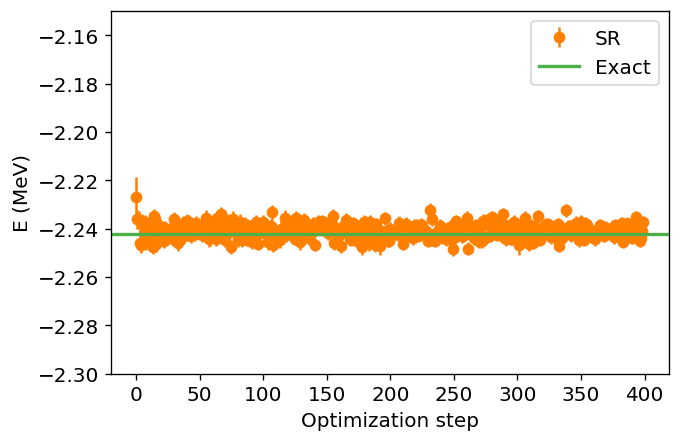

In [ ]:
from matplotlib.pyplot import figure
palette = plt.get_cmap('Set1')
figure(num=None, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

step = jnp.asarray(steps_history)
energy = jnp.asarray(energy_history)
error = jnp.asarray(error_history)

p1 = plt.errorbar(step, jnp.real(energy), yerr=jnp.real(error), fmt='o', errorevery=1, markevery = 1, zorder = 0, color = palette(4))
p2 = plt.axhline(y= -2.242, linestyle = '-', label = 'Exact', color = palette(2), lw = 2)

plt.ylim(-2.3,-2.15)
#plt.xlim(0,100)

plt.xlabel(r'Optimization step')
plt.ylabel('E (MeV)')
plt.legend([p1, p2], [r'SR', r'Exact'], loc = 'upper right')
plt.savefig("2H_energies.pdf",bbox_inches = 'tight')
plt.show()